# Estimating covariance matrix on SkySim5000 dark matter halo catalog

In [1]:
from IPython.display import Markdown
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate
import astropy.units as u
from astropy.table import Table
import GCRCatalogs

%matplotlib inline

In [2]:
skysim_cat = GCRCatalogs.load_catalog('skysim5000_v1.1.1_small')

In [3]:
cosmo_ss  = skysim_cat.cosmology
cosmo_ss

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

## Extract DM haloes from the catalog in a given mass and redshift range. 

In [4]:
%%time
mmin = 1.e12 # Msun (M_fof)
zmin = 0.
zmax = 1.0
dm_halos = Table(skysim_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id',
                                             'baseDC2/sod_halo_mass'],
                                            filters=[f'halo_mass > {mmin}','is_central==True',
                                            f'redshift>{zmin}', f'redshift<{zmax}']))
dm_halos['m200c'] = dm_halos['baseDC2/sod_halo_mass']/cosmo_ss.h

CPU times: user 20 s, sys: 46.2 s, total: 1min 6s
Wall time: 2min 44s


In [5]:
dm_halos = Table(dm_halos[dm_halos['m200c'] > 0])

In [6]:
print(min(np.log10(dm_halos['m200c'])), max(np.log10(dm_halos['m200c'])))

12.416299616712942 14.99328083707089


In [7]:
z_corner = np.linspace(0.25, 1, 10)
logm_corner = np.linspace(13, 14.5, 10)

In [19]:
type(dm_halos)

astropy.table.table.Table

In [21]:
import healpy
healpix = healpy.ang2pix(2**8, np.array(dm_halos['ra']), np.array(dm_halos['dec']), nest=True, lonlat=True)
healpix

array([550668, 550658, 550674, ..., 553579, 553204, 553209])

# Estimate the covariance matrix for binned cluster count

In [8]:
import CL_COUNT_DATAOPS_cluster_abundance_covariance as covariance

In [9]:
Covariance = covariance.Covariance_matrix()

## Bootstrap

In [11]:
Covariance.compute_boostrap_covariance(catalog = dm_halos, proxy_colname = 'm200c', 
                                    redshift_colname = 'redshift', proxy_corner = 10**logm_corner, 
                                    z_corner = z_corner, n_boot = 100)

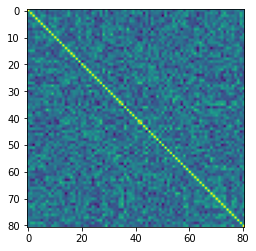

In [12]:
plt.imshow(np.corrcoef(Covariance.Bootstrap_covariance_matrix))

## Jackknife

In [13]:
Covariance.compute_jackknife_covariance_healpy(catalog = dm_halos, proxy_colname = 'm200c', 
                                           redshift_colname = 'redshift',z_corner = z_corner, 
                                           proxy_corner = 10**logm_corner, ra_colname = 'ra', 
                                           dec_colname = 'dec', n_power = 8, N_delete = 1)

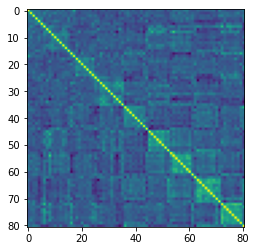

In [14]:
plt.imshow(np.corrcoef(Covariance.Jackknife_covariance_matrix))